# Getting Started Replaying Old Data

- Work under a separate branch with git (i.e. git checkout -b my-new-branch)

- Copy this ipynb file to a folder within your Projects folder - better not work within this (Projects_Templates/2_ReplayOldDataAsNF) folder. Come up with a nice name for the new folder.

- Then enter your new folder within Projects (maybe 3_New_Assignment_Fancy_Analysis), and use the code in here for for your purposes as you see fit

- you might wish to grab some data from Leipzig here: ldrive, under **Lab_MichaelB/Johan/nf/rawdata/ReplayDataTest**


- the main gist of re-playing existing data is:
    - that your first load everything into a big matrix with mne
    - then initialize a specific **amp** (i.e., the "replayamp")
    - then do exactly the same as normal, with a while True loop with calls to amp.get_data()
    
- you may wish to put all of the import statements at the top

- if you get a module not found error, add the mushu folder to the python path. A good analogy is the matlab's 'addpath' utility.


For example:
```python
sys.path.append('/home/nfcontrol/nf/nf-rtime/mushu/')      # this is to talk with the amplifer
sys.path.append('/home/nfcontrol/nf/nf-rtime/wyrm/') 
```


Not all of this code is useful! So remove the stuff you don't need, f.e. matplogib qt5, path appends, etc etc.

In [1]:
# import all the needed stuff:

import time
import matplotlib
import sys
import scipy
import numpy as np
import easygui
import matplotlib.pyplot as plt
import mne
from IPython.display import clear_output
import re
import pickle

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra

sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
# this is the replay notebook - so select a file for playback - this is for brainvision files.

fn=easygui.fileopenbox(default='/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/*.vhdr')
print(fn)

raw_fromfile = mne.io.read_raw_brainvision(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)

/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/T0007/eeg/ExpPre-Run01_0001_46.vhdr
Extracting parameters from /media/ldrive/Lab_MichaelB/Johan/nf/rawdata/T0007/eeg/ExpPre-Run01_0001_46.vhdr...
No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
Setting channel info structure...


<ipython-input-2-b397cd66af22>:6: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw_fromfile = mne.io.read_raw_brainvision(fn)


<RawBrainVision  |  ExpPre-Run01_0001_46.eeg, n_channels x n_times : 65 x 3452500 (690.5 sec), ~164 kB, data not loaded>

In [2]:
# this is the replay notebook - so select a file for playback - this is for eeglab files.

fn=easygui.fileopenbox(default='*.set')
print(fn)

raw_fromfile = mne.io.read_raw_eeglab(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)

/home/johan/nf/nf-rtime/Projects_Templates/2_ReplayOldDataAsNF/example_full_1000Hz.set
The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
1/2486 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file


<ipython-input-2-01dc4fc696ab>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_fromfile = mne.io.read_raw_eeglab(fn)
<ipython-input-2-01dc4fc696ab>:6: RuntimeWarning: Events like the following will be dropped entirely: ['boundary'], 1 in total
  raw_fromfile = mne.io.read_raw_eeglab(fn)
<ipython-input-2-01dc4fc696ab>:6: RuntimeWarning: 1/2486 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  raw_fromfile = mne.io.read_raw_eeglab(fn)
<ipython-input-2-01dc4fc696ab>:6: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_fromfile = mne.io.read_raw_eeglab(fn)


<RawEEGLAB  |  None, n_channels x n_times : 64 x 681120 (681.1 sec), ~332.7 MB, data loaded>

In [5]:
# prepare data for replay:

mul_factor = 1.0
if 1e-6 in [raw_fromfile.info['chs'][0]['cal'], raw_fromfile.info['chs'][0]['range']]:
    mul_factor = 1.0 / 1e-6

seed_d=raw_fromfile[:-1,:][0] * mul_factor  # scale the data to seed (so no 1e-6 stuff in the replayed data)
seed_d=np.array(seed_d.transpose())
seed_ch=raw_fromfile.ch_names[0:-1]
seed_fs=raw_fromfile.info['sfreq']

# prepare for replay; markers:
seed_mdata=np.transpose(raw_fromfile[-1,:][0])
seed_m=[[i / raw_fromfile.info['sfreq'] * 1000, int(m[0])] for i, m in enumerate(seed_mdata) if m > 0] 

In [6]:
seed_d.shape

(3452500, 64)

In [8]:
amp = libmushu.get_amp('replayamp')
amp.configure(seed_d, seed_m, seed_ch, seed_fs, realtime=True, blocksize_samples=100)

In [9]:
alld=[]     # this is all the data
allm=[]     # these are all the markers. Markers are given relative to the beginning of the data chunk you just got
            # so you have to do a calculation to give the markers relative to the start of the recording.
channels = []  

# some initializations
markTime=time.time()
updateTime = 0.1  # update every 100 msec.
buffSize = 1.0 # seconds
fs = amp.get_sampling_frequency()
channels=amp.get_channels()
rb = RingBuffer(buffSize * raw_fromfile.info['sfreq'])  # 5000 Sample buffer...

totalTime = seed_d.shape[0]/raw_fromfile.info['sfreq']

In [10]:
amp.start()

DEBUG:libmushu.ampdecorator:Waiting for marker server to become ready...
DEBUG:asyncio:Using selector: EpollSelector
DEBUG:libmushu.ampdecorator:Marker server is ready.


In [11]:
# l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
st=''
while curTime - t0 < totalTime:  # l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()

    
    # this is where you get the data
    data, marker = amp.get_data()
    cnt = io.convert_mushu_data(data, marker, fs, channels)
    newsamples = cnt.data.shape[0]

    
    rb.append(cnt)
    
    
    
    # do the following every 0.1 msec:
    if curTime - markTime > updateTime:
        # do Stuff
        
        markTime = curTime
        # 1) obtain last 1-second(s)
        d = rb.get()
        
        # thomas does stuff here
        
        
        # we send the value to BCI/STIM
        
        
        
        clear_output(wait=True)
        print('Playing Back - time = %f' % (curTime - t0))
        print('Length Markers: %d' % len(allm))
        print(data.shape)

        

        
    
    # append it to the big matrix
    alld.append(data)
    for m in marker:
        allm.append([m[0] + markeroffset, m[1]])
    markeroffset += newsamples / float(fs) * 1000.

Playing Back - time = 690.486239
Length Markers: 2555
(0, 64)


In [12]:
amp.stop()
alld=np.concatenate(alld)
ch_names=amp.get_channels()
sfreq=amp.get_sampling_frequency()

DEBUG:libmushu.ampdecorator:Waiting for marker server process to stop...
DEBUG:libmushu.ampdecorator:Marker server process stopped.


amplifier stopped!


In [14]:
alld.shape

(3452500, 64)

In [15]:
# write to disk, so we can re-load it later:
t={'alld':alld, 'allm':allm, 'ch_names':ch_names, 'sfreq':sfreq}
with open('c-allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [ ]:
# load from disk:
with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [16]:
raw = convert_alld_allm_to_mne(alld, allm, ch_names, sfreq)  # covert to MNE
raw.set_eeg_reference(ref_channels='average')

The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
Creating RawArray with float64 data, n_channels=64, n_times=3452500
    Range : 0 ... 3452499 =      0.000 ...   690.500 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=3452500


../../nftools/nftools/analysis.py:29: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
  montage=montage


    Range : 0 ... 3452499 =      0.000 ...   690.500 secs
Ready.
Applying average reference.
Applying a custom EEG reference.


<RawArray  |  None, n_channels x n_times : 65 x 3452500 (690.5 sec), ~1.67 GB, data loaded>

In [17]:
raw.resample(1000)

2555 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  26  30  31
  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82  83
  84  85  86 131 132 133 134 135 136 140 201 202 203 204 221 222 223 224
 225 226 227 228 229 231 232 233 234 241 242 243 244 245 246 247]
2555 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  26  30  31
  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82  83
  84  85  86 131 132 133 134 135 136 140 201 202 203 204 221 222 223 224
 225 226 227 228 229 231 232 233 234 241 242 243 244 245 246 247]


<RawArray  |  None, n_channels x n_times : 65 x 690500 (690.5 sec), ~342.6 MB, data loaded>

In [4]:
newraw_eo=select_part_from_mne_dataset(raw_fromfile, markers=[201, 202])
newraw_ec=select_part_from_mne_dataset(raw_fromfile, markers=[203, 204])

using markers
2555 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  26  30  31
  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82  83
  84  85  86 131 132 133 134 135 136 140 201 202 203 204 221 222 223 224
 225 226 227 228 229 231 232 233 234 241 242 243 244 245 246 247]
using boundaries
[[ 1.5810e-03  1.5815e-03  1.5820e-03 ...  2.6400e-03  2.6405e-03
   2.6420e-03]
 [-2.5555e-03 -2.5555e-03 -2.5550e-03 ... -8.2105e-03 -8.2090e-03
  -8.2085e-03]
 [ 5.1450e-04  5.1400e-04  5.1450e-04 ...  1.5565e-03  1.5570e-03
   1.5585e-03]
 ...
 [-9.8450e-04 -9.8450e-04 -9.8450e-04 ... -1.5850e-03 -1.5850e-03
  -1.5840e-03]
 [-4.6250e-04 -4.6200e-04 -4.6250e-04 ... -1.5775e-03 -1.5770e-03
  -1.5775e-03]
 [ 2.0100e+02  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
Creating RawArray with float64 data, n_channels=65, n_times=250048
    Range : 0 ... 250047 =      0.000 ...    50.009 secs
Ready.
using markers
2555 events found


In [11]:
# split data sets between EO and EC

newraw_eo=select_part_from_mne_dataset(raw, markers=[201, 202])
newraw_ec=select_part_from_mne_dataset(raw, markers=[203, 204])

NameError: name 'raw' is not defined

In [6]:
%matplotlib qt5

DEBUG:matplotlib.backends:backend Qt5Agg version 5.9.2


In [7]:
plt.figure();plt.plot(newraw_ec[[c['ch_name'] for c in newraw_ec.info['chs']].index('Oz'),0:50000][0].transpose()*500000)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


In [10]:
d1=plot_compare_two_spectra(newraw_eo, newraw_ec, freqs=[1, 25], n_fft=2048*8, n_overlap=512*8, chs_to_include=['Oz','O1','O2','PO8'], freq_lims_topoplot=[10.43], pow_lims = [-10, 25])


Effective window size : 3.277 (s)
Effective window size : 3.277 (s)
['Oz', 'O1', 'O2', 'PO8']
[8, 9, 19, 58]


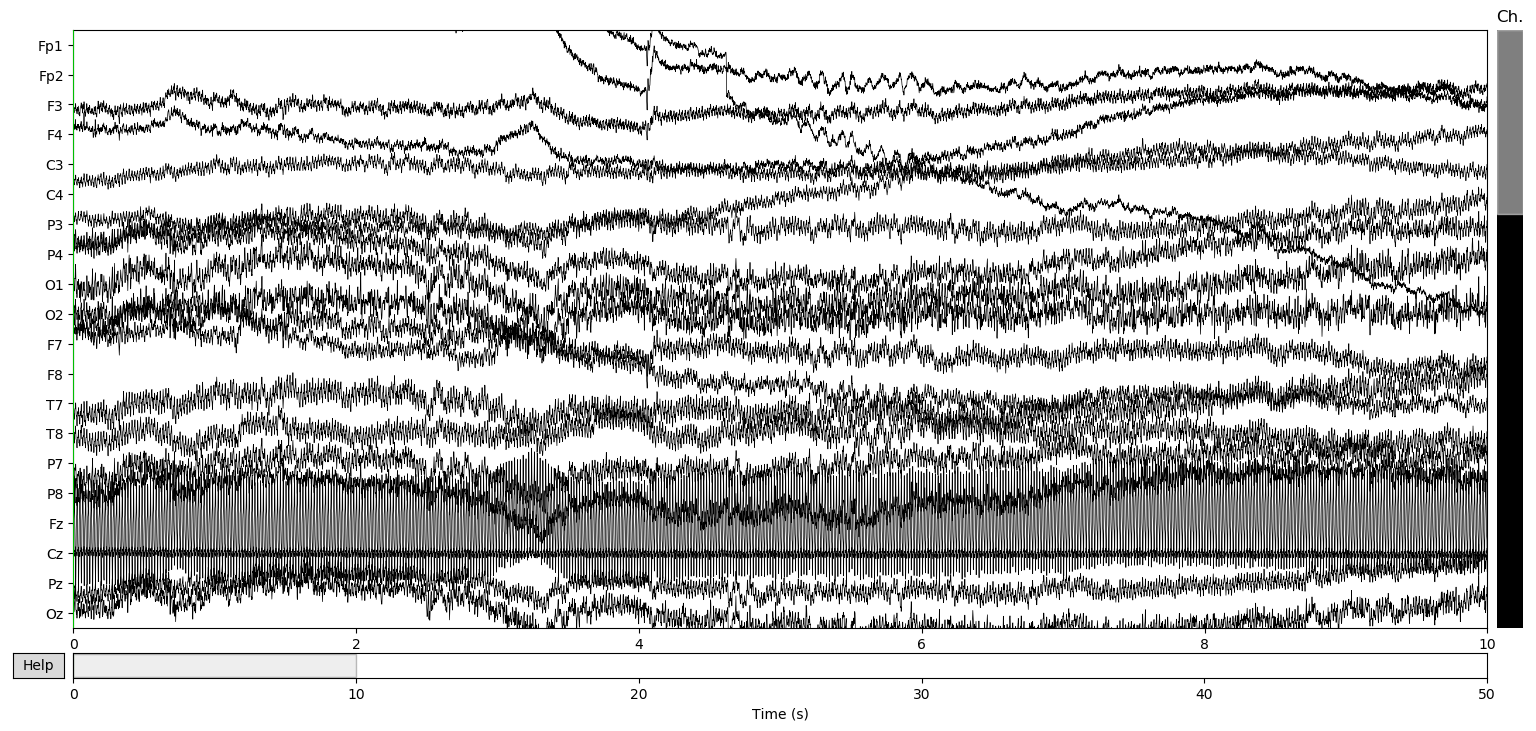

In [11]:
newraw_eo.plot()

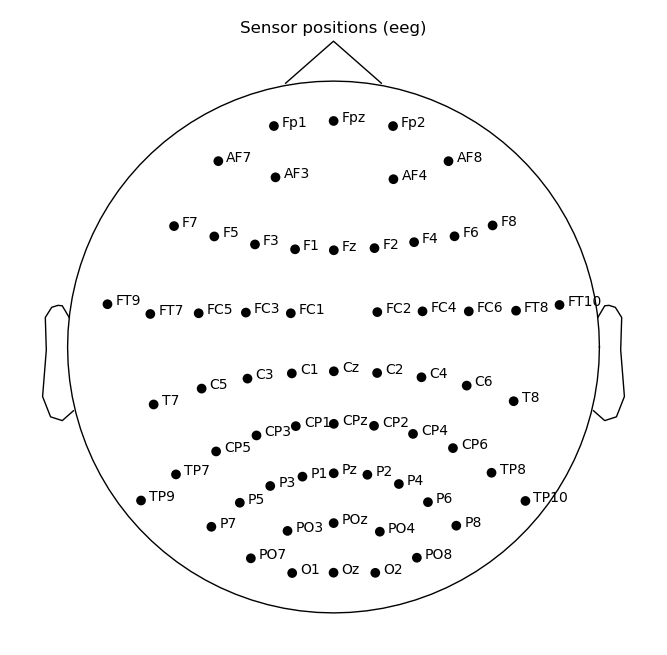

In [11]:
mne.viz.plot_sensors(newraw_ec.info, show_names=True)

In [20]:
from mne.preprocessing import ICA
method = 'fastica'
n_components = 25
decim = 3
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

picks_eeg = mne.pick_types(newraw_ec.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
reject = dict(eeg=1e-3)
ica.fit(newraw_ec, picks=picks_eeg, decim=decim, reject=reject)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'C4', 'P3', 'P4', 'F7', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Pz', 'Oz', 'FC1', 'CP2', 'CP5', 'TP9', 'TP10', 'C1', 'C2', 'P2', 'AF4', 'FC3', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P6', 'AF7', 'AF8', 'FT7', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'CPz']
Artifact detected in [40008, 43342]
    Rejecting  epoch based on EEG : ['AF8']
Artifact detected in [50010, 53344]
Selection by number: 25 components
Fitting ICA took 4.7s.
<ICA  |  raw data decomposition, fit (fastica): 76682 samples, 25 components, channels used: "eeg">


/home/johan/.conda/envs/rt/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Effective window size : 3.277 (s)


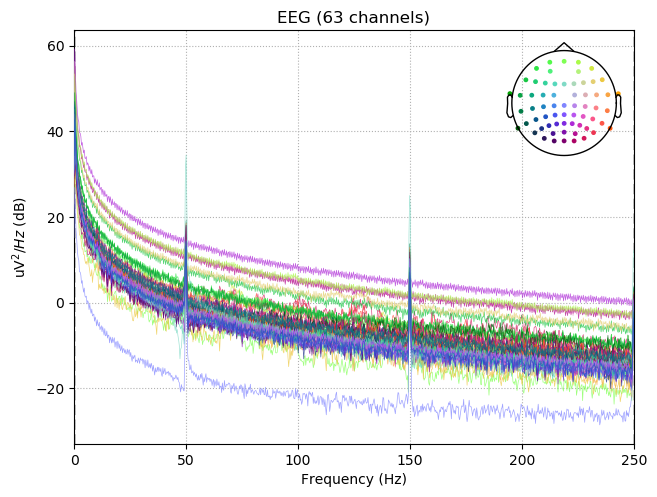

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


In [26]:
newraw_ec.plot_psd(tmax=np.inf, fmax=250, n_fft=16384)

In [21]:
ica.plot_components()

[<Figure size 750x700 with 20 Axes>, <Figure size 750x250 with 5 Axes>]

In [23]:
ica.plot_properties(newraw_ec, picks=0)

    using multitaper spectrum estimation with 7 DPSS windows


/home/johan/.conda/envs/rt/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


[<Figure size 700x600 with 5 Axes>]

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralB

In [ ]:
# split data sets between EO and EC

newraw_l8=select_part_from_mne_dataset(raw, markers=[83, 85])
newraw_r8=select_part_from_mne_dataset(raw, markers=[84, 86])
mne.concatenate_raws([newraw_l8, newraw_l13])  # this lengthens l8 - with l 13

newraw_l13=select_part_from_mne_dataset(raw, markers=[133, 135])
newraw_r13=select_part_from_mne_dataset(raw, markers=[134, 136])
mne.concatenate_raws([newraw_r8, newraw_r13])  # this lengthens r8 - with r 13

In [ ]:
d1, ma1, mb1=plot_compare_two_spectra(newraw_l8, newraw_r8, freqs=[1, 30], n_fft=2048, n_overlap=512, chs_to_include=['O1', 'O2','Oz'], freq_lims_topoplot=[11, 12], pow_lims = [-10, 20])

In [ ]:
%matplotlib qt5
raw.plot()

## Done!
